# Imports and Setup

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
import cv2
import os
from collections import defaultdict
import re
import pickle

import warnings
warnings.filterwarnings("ignore")

# Visualizing Raw Filters

In [2]:
np.random.seed(0)

# Load pretrained AlexNet
alexnet = torchvision.models.alexnet(pretrained=True)
alexnet.eval()  # set to evaluation mode

# Extract the first convolutional layer filters
first_conv = alexnet.features[0]
filters = first_conv.weight.data.clone().cpu().numpy()  # shape: [out_channels, in_channels, height, width]

print("First layer filters shape:", filters.shape)

First layer filters shape: (64, 3, 11, 11)


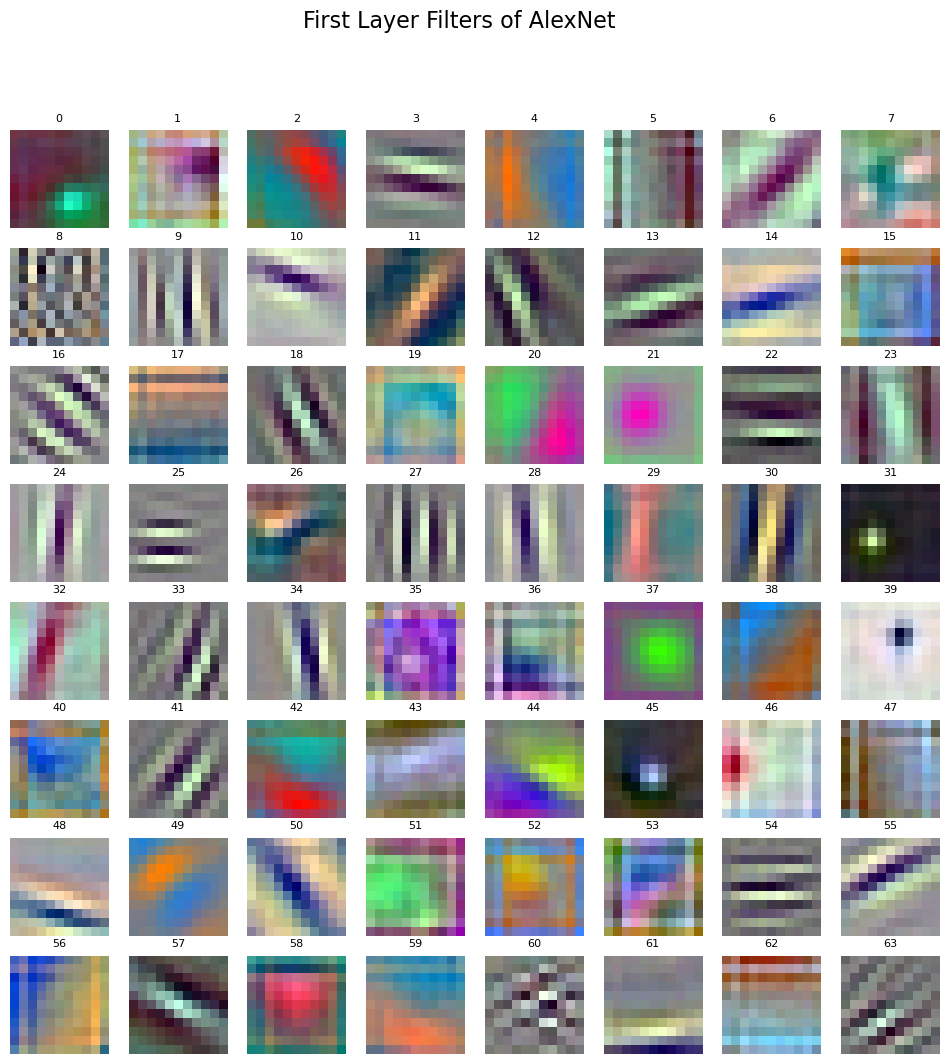

In [3]:
# Plot all 64 filters
fig, axes = plt.subplots(8, 8, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    if i >= 64:
        break
    filt = filters[i]  # Shape: (3, 11, 11)

    # Normalize filter for visualization
    filt = (filt - filt.min()) / (filt.max() - filt.min())  # Normalize to [0,1]
    
    # Convert to RGB image format
    filt = filt.transpose(1, 2, 0)  # (3, 11, 11) -> (11, 11, 3)
    
    ax.imshow(filt)
    ax.set_title(i, fontsize=8)
    ax.axis("off")

plt.suptitle("First Layer Filters of AlexNet", fontsize=16)
plt.show()

In [4]:
#filter groupings
filter_groups = {
    "single_edge": [3, 6, 10, 11, 12, 13, 14, 23, 24, 28, 29, 30, 32, 34, 43, 48, 49, 50, 55, 57], #gabor-like / edge detector
    "multi_edge": [9, 16, 18, 22, 25, 27, 33, 41, 54, 63], #complex gabor / complex edge detector
    "eye": [21, 31, 37, 39, 45, 46,], # color contrast
    "dual_color": [0, 2, 4, 5, 17, 20, 26, 38, 42, 44, 47, 56, 59], # color contrast
    "inside_out": [7, 15, 19, 35, 40, 51, 52, 53, 58], # smoothing
    "misc": [1, 8, 36, 60, 61, 62] # misc
}

sum([len(i) for i in filter_groups.values()])

64

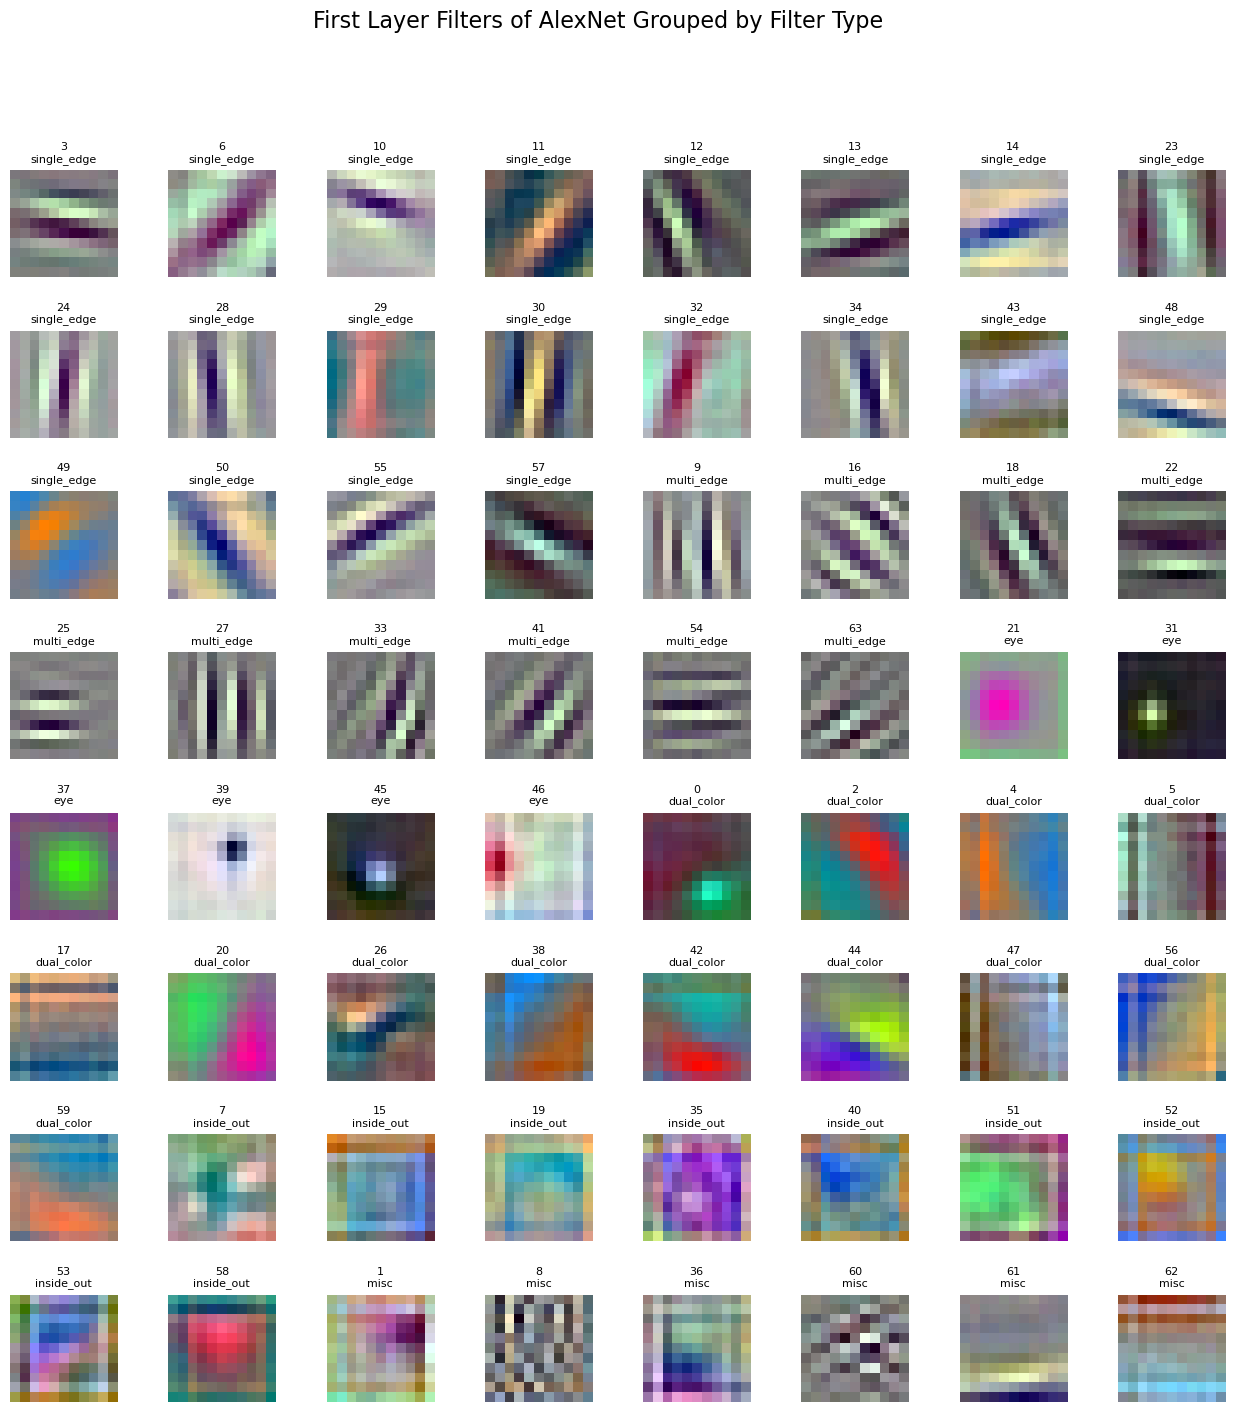

In [5]:
num_filters = 64
rows = int(np.ceil(num_filters / 8))

fig, axes = plt.subplots(rows, 8, figsize=(16, rows * 2))
axes = axes.flatten()

i = 0
for group, indices in filter_groups.items():
    for idx in indices:
        filt = filters[idx]  # Shape: (3, 11, 11)

        # Normalize filter for visualization
        filt = (filt - filt.min()) / (filt.max() - filt.min())  # Normalize to [0,1]
        
        # Convert to RGB image format
        filt = filt.transpose(1, 2, 0)  # (3, 11, 11) -> (11, 11, 3)
        
        axes[i].imshow(filt)
        axes[i].set_title(f"{idx}\n{group}", fontsize=8)
        axes[i].axis("off")
        i += 1

# Remove unused axes if any
for j in range(i, len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(hspace=0.5) 
plt.suptitle("First Layer Filters of AlexNet Grouped by Filter Type", fontsize=16)
plt.show()


# Visualizing Filter Effects on a Specific Dataset

In [ ]:
data_path = "" # your data path
#"/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/dataset-preparation/raw-data/coco/toy-coco-cropped-allObjects/"

In [7]:
def apply_learned_filters(image, filters, device='cpu'):
    """
    image: a numpy array of shape (H, W, 3) in range [0, 255] or normalized appropriately.
    filters: numpy array of shape (num_filters, in_channels, kH, kW).
    Returns: list of feature maps (one per filter).
    """
    # Convert image to a tensor and add batch dimension: shape [1, 3, H, W]
    # Assume image is in HxWxC format and normalized [0,1].
    transform = transforms.ToTensor()  # converts to range [0, 1] and shape (C, H, W)
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Convert filters to torch tensor and place on the same device.
    filter_tensor = torch.tensor(filters, dtype=torch.float32).to(device)
    
    # Convolve the image with all filters. You can use groups=1 (assuming full connectivity).
    # If using a subset of filters, adjust the shape accordingly.
    feature_maps = F.conv2d(image_tensor, filter_tensor, bias=None, stride=1, padding=first_conv.padding)
    
    # feature_maps shape: [1, num_filters, H_out, W_out]
    return feature_maps.squeeze(0).cpu().detach().numpy()  # shape: (num_filters, H_out, W_out)

def visualize_filter_effect(image, filters, filter_index, device='cpu'):
    """
    Applies a specific filter from AlexNet's first layer to an image and visualizes the result.

    Parameters:
    - image: Input image (numpy array of shape (H, W, 3))
    - filters: Pretrained AlexNet filters (NumPy array of shape (num_filters, in_channels, kH, kW))
    - filter_index: Index of the filter to apply
    - device: 'cpu' or 'cuda' for computation

    Returns:
    - Displays the original and filtered image side by side
    """
    # Convert image to tensor
    transform = transforms.ToTensor()  
    image_tensor = transform(image).unsqueeze(0).to(device).float()  # Shape: (1, 3, H, W)

    # Extract the specific filter
    selected_filter = torch.tensor(filters[filter_index:filter_index+1], dtype=torch.float32).to(device)  # Shape: (1, 3, kH, kW)

    # Apply convolution
    feature_map = F.conv2d(image_tensor, selected_filter, bias=None, stride=1, padding=1)
    feature_map = feature_map.squeeze(0).cpu().detach().numpy()  # Shape: (1, H_out, W_out)

    # Normalize feature map for visualization
    feature_map = feature_map[0]
    feature_map -= feature_map.min()
    feature_map /= feature_map.max()

    # Plot original image and filtered output
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    #ax[1].imshow(feature_map, cmap='gray')
    ax[1].imshow(feature_map, cmap='gray')
    ax[1].set_title(f"Filtered Image (Filter {filter_index})")
    ax[1].axis("off")

    plt.show()

Group 1: single_edge


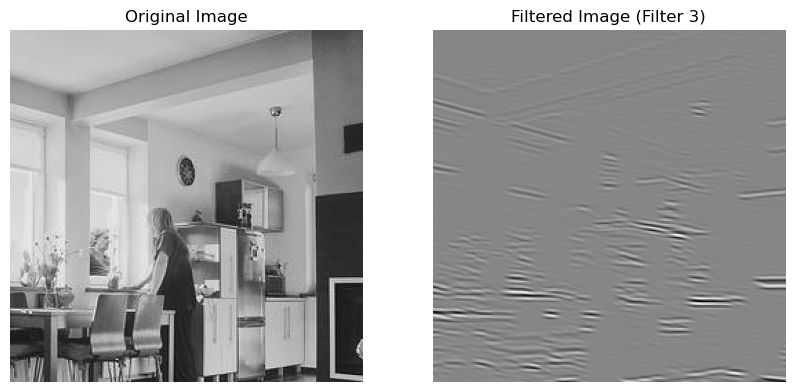

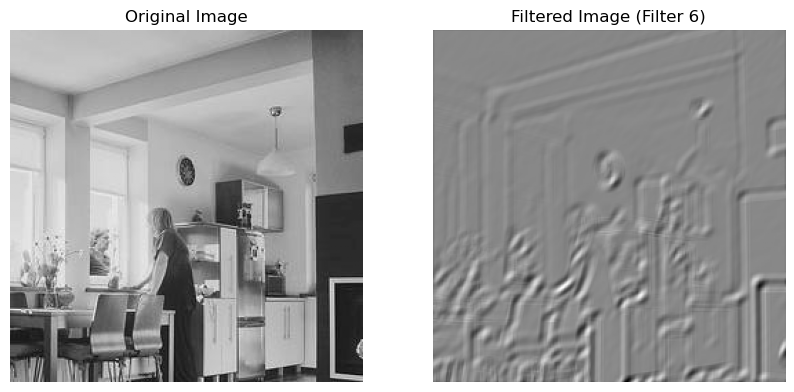

Group 2: multi_edge


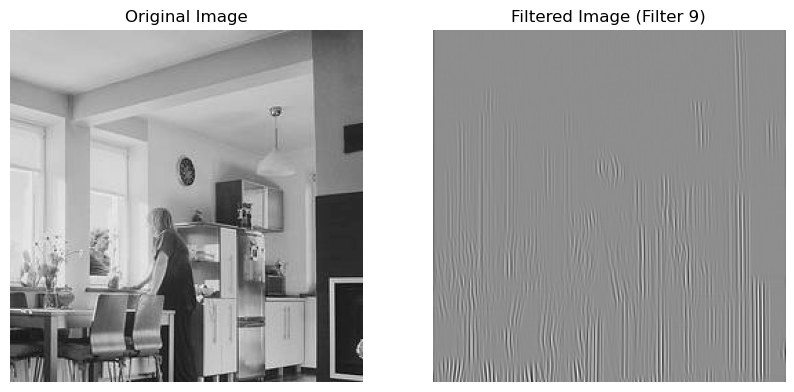

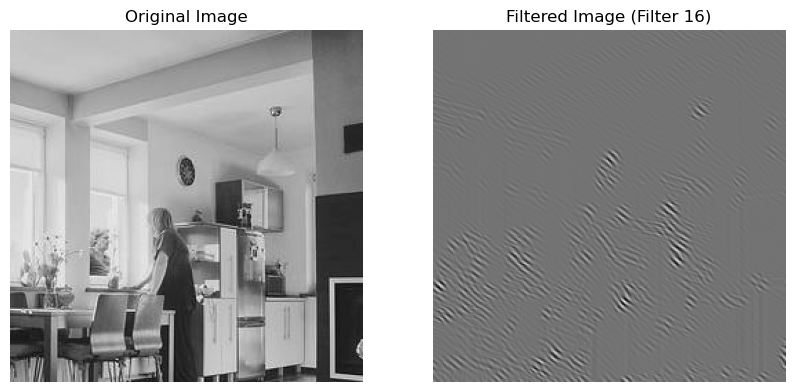

Group 3: eye


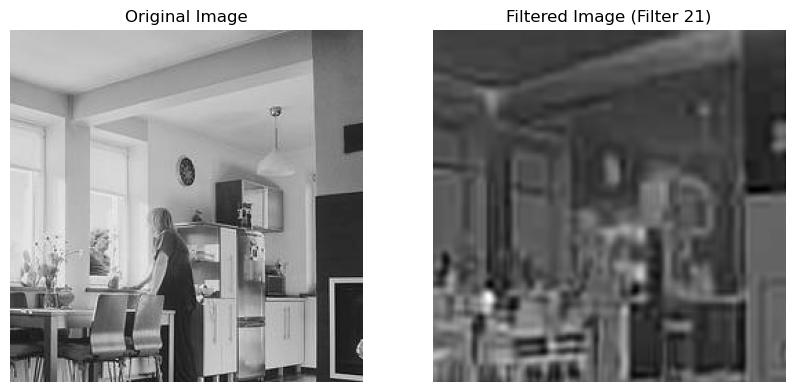

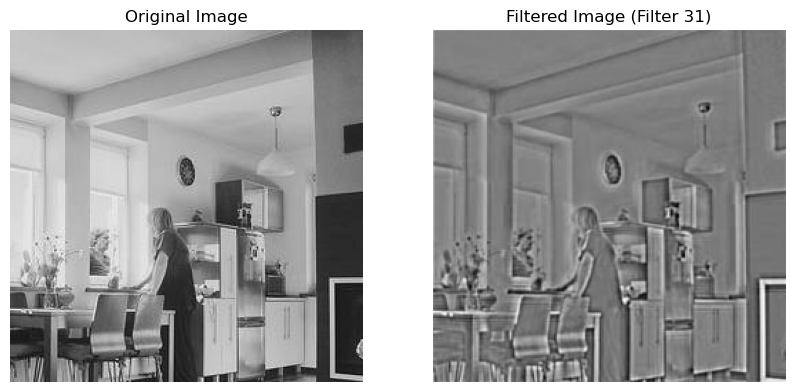

In [ ]:
random_image = False
img_path = "" # the path to the image you want to test
#"/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/dataset-preparation/raw-data/coco/toy-coco-cropped-allObjects/000000000139.jpg"

if not random_image:
    img = cv2.imread(img_path)

else:
    img = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)  # Random image for testing

n_groups = 3
n_per_group = 2

filter_keys = list(filter_groups.keys())

for i in range(n_groups):
    group = filter_keys[i]
    group_filters = filter_groups[group]
    print(f"Group {i+1}: {group}")
    for i in range(len(group_filters)):
        if i >= n_per_group:
            break
        visualize_filter_effect(img, filters, filter_index=group_filters[i])

# Filter Coefficient Distributions on Dataset

In [15]:
def load_images_from_directory(directory, n=None, pastis=False):
    """
    Loads images from a directory.
    """
    if not n:
        n = len(os.listdir(directory))
    images = []
    for filename in os.listdir(directory)[:n]:
        if pastis:
            img = np.load(os.path.join(directory, filename))["image"].astype(np.float32)
        else:
            img = cv2.imread(os.path.join(directory, filename))
        images.append(img)
    return np.array(images)

def transform_images(images, filters, device='cpu'):
    num_filters = len(filters)
    
    # Initialize a list of empty lists for each filter
    concatenated_filters = [[] for _ in range(num_filters)]
    for img in images:
        img_map = apply_learned_filters(img, filters, device)
        for j in range(num_filters):
            concatenated_filters[j] = np.concatenate((concatenated_filters[j], img_map[j].flatten()))

    return np.array(concatenated_filters)

def plot_feature_distribution(feature_maps, filter_index=0):
    """
    Plots histogram and KDE of a given filter's output.
    feature_maps: numpy array of shape (num_filters, H, W)
    filter_index: which filter to plot
    """
    coefficients = feature_maps[filter_index].flatten()
    
    plt.figure(figsize=(8, 5))
    sns.histplot(coefficients, bins=50, kde=True, stat = 'probability')
    plt.title(f'Coefficient Distribution for Filter {filter_index}. n = {len(coefficients)}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Frequency')
    plt.xlim(-3, 3)
    plt.show()

def plot_group_distribution(all_group_coef):
    for group in all_group_coef.keys():
        for i in range(len(all_group_coef[group])):

            coefficients = all_group_coef[group][i].flatten()

            plt.figure(figsize=(8, 5))
            sns.histplot(coefficients, bins=50, kde=True, stat = 'probability')
            plt.title(f'Coefficient Distribution for Group {group}, Filter {filter_groups[group][i]}. n = {len(coefficients)}')
            plt.xlabel('Coefficient Value')
            plt.ylabel('Frequency')
            plt.xlim(-3, 3)
            plt.show()

In [ ]:
n = None # the number of images to load, or None to load all

images = load_images_from_directory(data_path, pastis=False, n=n)

filter_groups_coef = {
    key: filters[val] for key, val in filter_groups.items()
}

transform_coef = transform_images(images, filters) # by alex_idx

group_transform_coef = {group: transform_images(images, filter_groups_coef[group]) for group in filter_groups.keys()} # by group

## Visualize the Distributions of a Subset of Filters

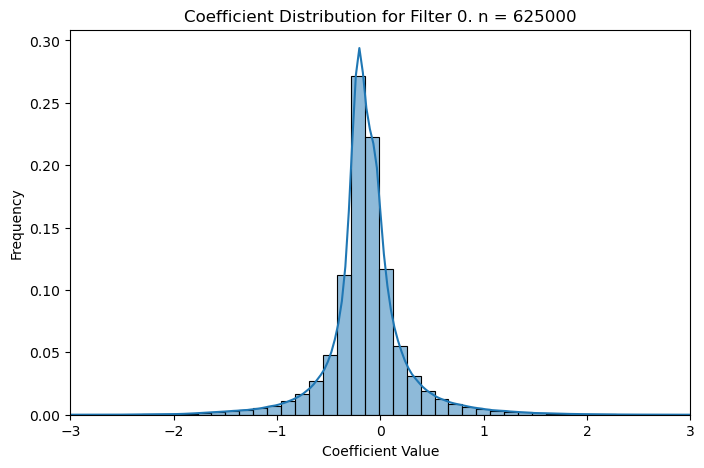

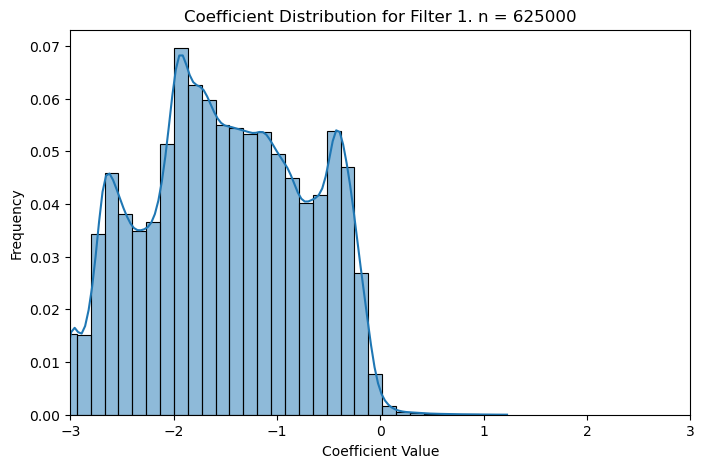

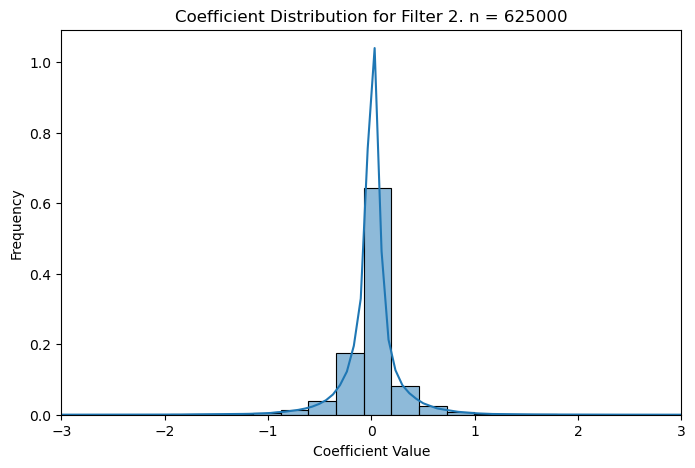

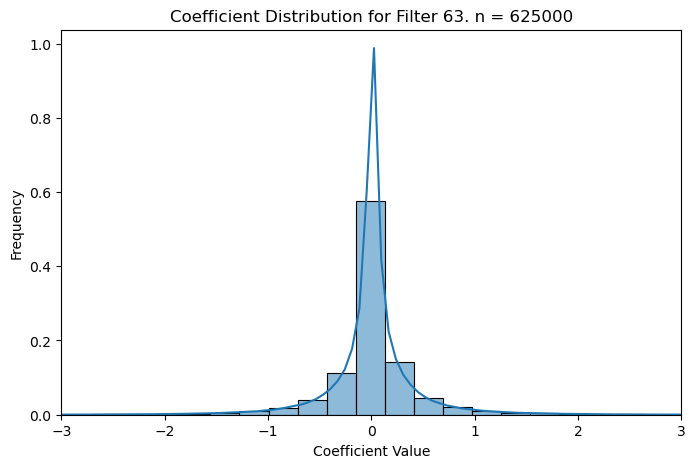

In [16]:
alex_idxs = [0, 1, 2, 63] # the Alex Indices of the filters to plot

for i in alex_idxs:
    plot_feature_distribution(transform_coef, filter_index=i)

## Visualize the Distributions of Filter Groups

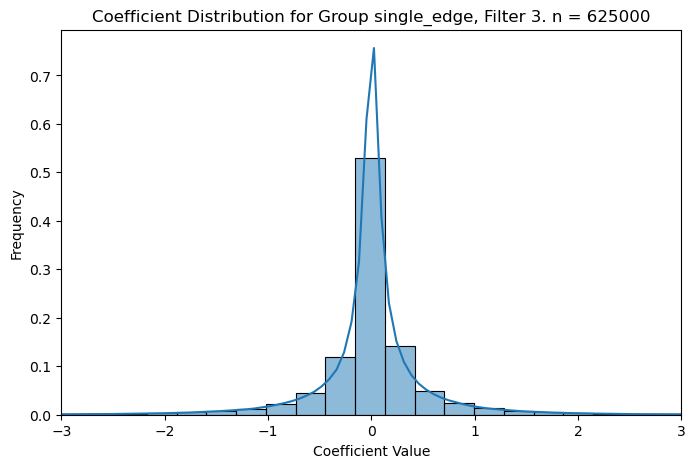

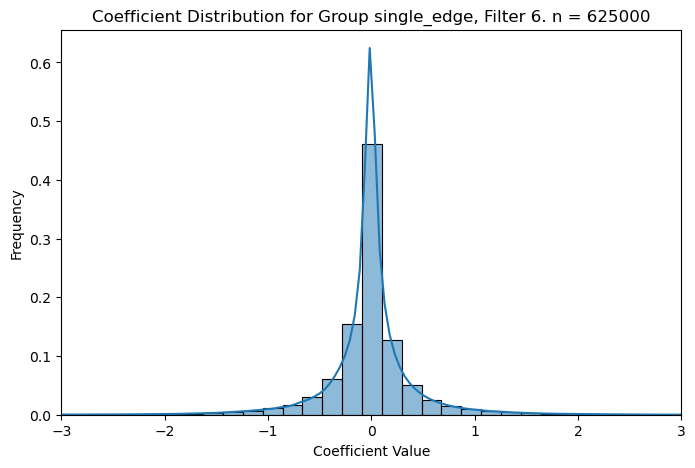

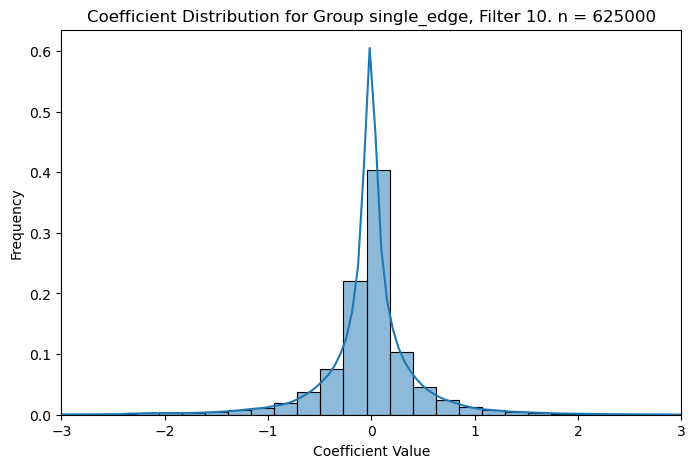

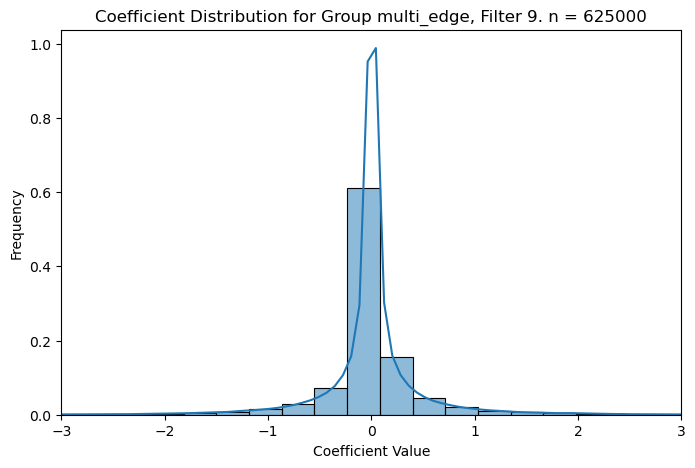

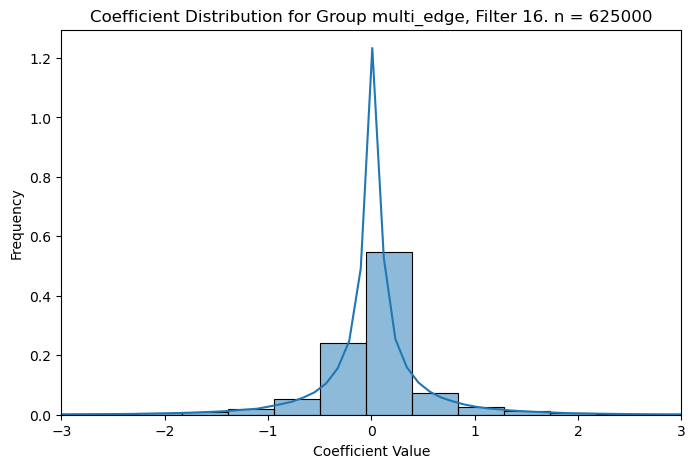

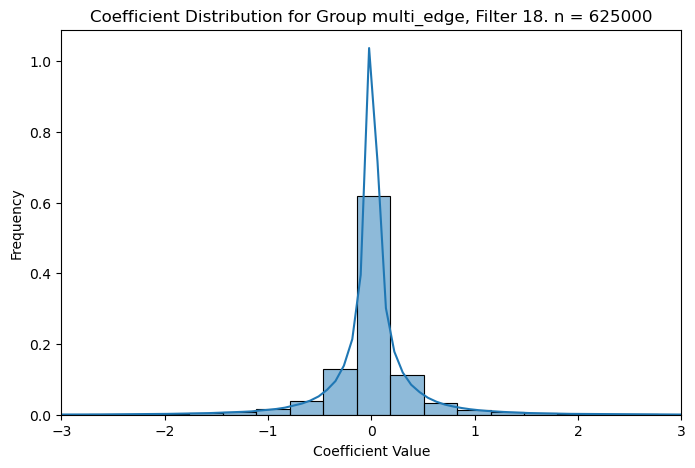

In [18]:
n_groups = 2
n_per_group = 3

subset_dict = {group: group_transform_coef[group][:n_per_group] for group in list(group_transform_coef.keys())[:n_groups]}

plot_group_distribution(subset_dict)